## basic classifier for Dna2Vec represenation

Basic bacterial genome classification using Dna2Vec representation

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
#export
import sys
sys.path.append("..")
from faigen.data import sequence 
from faigen.data.sequence import regex_filter, count_filter, Dna2VecDataBunch
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as py
import plotly.graph_objs as go
from fastai import *
from fastai.data_block import *
from fastai.basic_train import *
from fastai.layers import *
from fastai.metrics import *
from gensim.models import Word2Vec
import torch 
import torch.nn as nn
import torch.nn.functional as F
import gc

### Load Data

In [3]:
#export
if __name__=='__main__':

SyntaxError: unexpected EOF while parsing (<ipython-input-3-eb05e039e64b>, line 2)

In [2]:
#export
print("Loading embedding")
word_vectors = Word2Vec.load_word2vec_format('../faigen/pretrained/embeddings/dna2vec-20190611-1940-k8to8-100d-10c-4870Mbp-sliding-LmP.w2v') 

Loading embedding


In [3]:
#export
# DB="/data/genomes/GenSeq_fastas"
# DB='/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes'
DB="/home/serge/database/data/genomes/ncbi-genomes-2019-04-07/Bacillus"

bunch=None
learner=None
gc.collect()

#filters=[partial(regex_filter, rx="Streptomyces|Staphylococcus|Vibrio|Rhizobium"),partial(regex_filter, rx="plasmid?\s", keep=False)]    
#        partial(count_filter,num_fastas=(1,1), keep=1)]

bunch = Dna2VecDataBunch.from_folder(DB,
             filters=[],
             labeler=lambda x: " ".join(x.split()[1:3]),
             emb=word_vectors,ngram=11,skip=0,
             n_cpus=7,agg=partial(np.mean, axis=0))

  1%|          | 2/241 [00:00<00:13, 17.97it/s]

  2%|▏         | 2/82 [00:00<00:04, 17.44it/s]

  2%|▏         | 4/241 [00:00<00:07, 33.40it/s]

Reading sequences


100%|██████████| 241/241 [00:06<00:00, 39.11it/s]

Tokenizing


Vectorizing
606


  0%|          | 0/82 [00:00<?, ?it/s]

Reading sequences


100%|██████████| 82/82 [00:04<00:00, 18.72it/s]

Tokenizing


Vectorizing
194


In [40]:
bunch.export("Bacillus.pkl")

In [20]:
from sklearn.feature_selection import SelectKBest

In [21]:
bunch.valid_ds.y.items.shape, len(bunch.valid_ds.x.items)

((194,), 194)

In [30]:
X = list(bunch.train_ds.x.items)+list(bunch.valid_ds.x.items)

In [32]:
y = list(bunch.train_ds.y.items)+list(bunch.valid_ds.y.items)

In [35]:
import pandas as pd
bacillus_df = pd.DataFrame(data=X)
bacillus_df["target"] = y

In [38]:
bacillus_df.to_csv("../data/Bacillus-8mer.csv")

In [44]:
scorer = SelectKBest()
X_10 = scorer.fit_transform(X, y)
bacillus_10_df = pd.DataFrame(data=X_10)
bacillus_10_df["target"] = y

In [45]:
from fastai.tabular import * 

In [46]:
dep_var = 'target'
valid_idx = range(len(bacillus_10_df)-80, len(bacillus_10_df))

In [67]:
data = TabularDataBunch.from_df("../data", bacillus_10_df, dep_var, valid_idx=valid_idx)

In [68]:
learn = tabular_learner(data, layers=[20,10], metrics=accuracy)

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


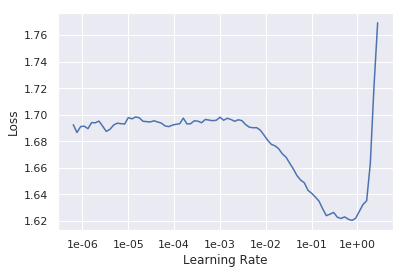

In [70]:
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(19, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.692085,1.568736,0.262500,00:01
1,1.678345,1.565937,0.262500,00:01
2,1.653293,1.565222,0.262500,00:01
3,1.623039,1.574800,0.250000,00:01
4,1.592699,1.607689,0.250000,00:01
5,1.562963,1.645548,0.250000,00:01
6,1.536528,1.654057,0.250000,00:01
7,1.511987,1.677109,0.250000,00:01
8,1.494778,1.736768,0.237500,00:01
9,1.481087,1.711942,0.262500,00:01


In [66]:
max(y)

4

In [30]:
print("Creating Learner")
layers=[
        nn.Linear(bunch.train_dl.x.c,100),nn.ReLU6(),
        nn.Linear(100,100),nn.ReLU6(),
        nn.BatchNorm1d(100),
        nn.Linear(100,21),nn.ReLU6(),
        nn.BatchNorm1d(21),
        nn.Dropout(0.5),
        nn.Linear(21,bunch.train_dl.y.c)]
bac_classifier = SequentialEx(*layers)
print(bac_classifier)
learn = Learner(bunch, bac_classifier, metrics=[accuracy])

Creating Learner
SequentialEx(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU6()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU6()
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=100, out_features=21, bias=True)
    (6): ReLU6()
    (7): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5)
    (9): Linear(in_features=21, out_features=5, bias=True)
  )
)


In [11]:
bunch.train_dl.y.c

5

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


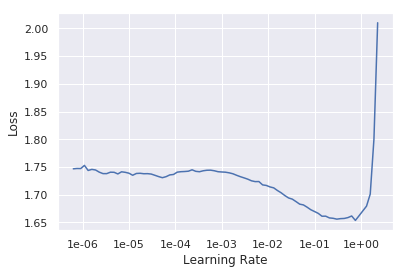

In [29]:
learn.lr_find();learn.recorder.plot()

In [31]:
print ("Training")
learn.fit_one_cycle(10,5e-3)

Training


epoch,train_loss,valid_loss,accuracy,time
0,1.680021,1.568475,0.365979,00:01
1,1.644321,1.557220,0.365979,00:01
2,1.615756,1.543324,0.365979,00:01
3,1.585456,1.537052,0.365979,00:01
4,1.564552,1.532194,0.365979,00:01
5,1.538424,1.551517,0.365979,00:01
6,1.526740,1.541531,0.365979,00:01
7,1.512003,1.538530,0.365979,00:01
8,1.498191,1.544300,0.365979,00:01
9,1.487355,1.560631,0.365979,00:01


In [33]:
b=bunch.one_batch()

In [42]:
dir(bunch.train_dl.y)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bunch',
 '_get_by_folder',
 '_label_cls',
 '_label_from_list',
 '_label_list',
 '_processor',
 '_relative_item_path',
 '_relative_item_paths',
 '_split',
 '_square_show',
 '_square_show_res',
 'add',
 'analyze_pred',
 'c',
 'c2i',
 'classes',
 'copy_new',
 'databunch',
 'filter_by_folder',
 'filter_by_func',
 'filter_by_rand',
 'filter_missing_y',
 'from_csv',
 'from_df',
 'from_folder',
 'get',
 'get_label_cls',
 'ignore_empty',
 'inner_df',
 'items',
 'label_cls',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_re',


In [45]:
bunch.train_dl.y.c2i

{'Bacillus anthracis': 0,
 'Bacillus subtilis': 1,
 'Bacillus cereus': 2,
 'Bacillus velezensis': 3,
 'Bacillus thuringiensis': 4}

In [35]:
print ("Training")
learn.fit_one_cycle(10,5e-1)

Training


epoch,train_loss,valid_loss,accuracy,time
0,1.517771,1.536819,0.365979,00:00
1,1.518076,1.537140,0.365979,00:00
2,1.521607,1.564627,0.365979,00:00
3,1.569962,3.361804,0.185567,00:00
4,1.631927,1.762733,0.365979,00:00
5,1.666953,218.889984,0.185567,00:00
6,1.675805,130.557251,0.185567,00:00
7,1.667572,101.857735,0.185567,00:00
8,1.649913,50.720848,0.185567,00:00
9,1.623518,21.495054,0.185567,00:00


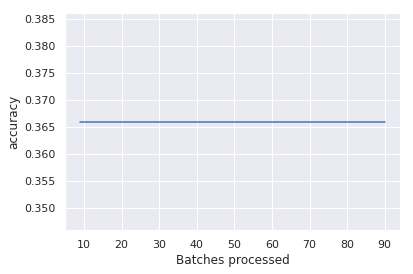

In [24]:
learn.recorder.plot_metrics()

In [14]:
learn.recorder.metrics

[[tensor(0.1546)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)],
 [tensor(0.3660)]]

In [17]:
learn.predict(10)[0]

Category 3

In [176]:
i

tensor(2)

In [184]:
!python notebook2script.py BacteriaClassifier.ipynb

../exp/nb_BacteriaClassifier.py
Converted BacteriaClassifier.ipynb to ../exp/nb_BacteriaClassifier.py


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


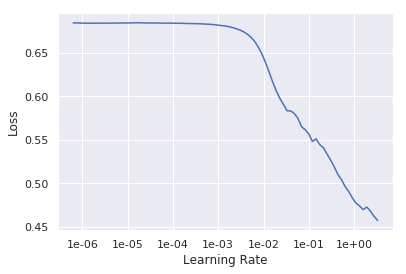

In [24]:
learn.recorder.plot()

In [ ]:
%debug

> /home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/torch/utils/data/dataloader.py(608)_process_next_batch()
    606                 raise Exception("KeyError:" + batch.exc_msg)
    607             else:
--> 608                 raise batch.exc_type(batch.exc_msg)
    609         return batch
    610 

ipdb> batch


In [10]:
len(data.items)

1686

###  Genome vectors

## Genome Inventory

In [156]:
inv=pd.read_pickle('/home/serge/database/data/genomes/ncbi-genomes-2019-04-07/inventory/sequences_by_label.pkl').reset_index()

In [157]:
inv.head()

,label,seq_count,id,lengths,min,max,median,files,file_count
0,'Catharanthus roseus',1,[NZ_CP035949.1],[600116],600116,600116,600116.0,[/home/serge/database/data/genomes/ncbi-genome...,1
1,'Deinococcus soli',1,[NZ_CP011389.1],[3236984],3236984,3236984,3236984.0,[/home/serge/database/data/genomes/ncbi-genome...,1
2,'Nostoc azollae',1,[NC_014248.1],[5354700],5354700,5354700,5354700.0,[/home/serge/database/data/genomes/ncbi-genome...,1
3,"18,711,729 reads",1,[NZ_CP033612.1],[2899315],2899315,2899315,2899315.0,[/home/serge/database/data/genomes/ncbi-genome...,1
4,Acaryochloris marina,1,[NC_009925.1],[6503724],6503724,6503724,6503724.0,[/home/serge/database/data/genomes/ncbi-genome...,1


In [161]:
def filter_by_count(df:pd.DataFrame, min=1)->pd.DataFrame:
    res=df.copy()
    drop = res.index[res.index.values[np.asarray(res.seq_count.values) < min]]
    res.drop(drop, axis=0,inplace=True)
    return res.reset_index(drop=True)


def filter_by_label(df:pd.DataFrame, word:str)->pd.DataFrame:
    res,mask=df.copy(),[]
    for x in df.label.values: mask.append(False if word in x else True)
    drop = res.index[mask]
    res.drop(drop, axis=0,inplace=True)
    return res.reset_index(drop=True)


In [172]:
short_list = filter_by_count(filter_by_label(inv,"Bacillus "), 40)

In [173]:
short_list

,label,seq_count,id,lengths,min,max,median,files,file_count
0,Bacillus anthracis,51,"[NZ_CP018903.1, NZ_AP018443.1, NZ_CP009325.1, ...","[5227565, 5219278, 5221627, 5210966, 5231857, ...",5200082,5321900,5227565.0,[/home/serge/database/data/genomes/ncbi-genome...,51
1,Bacillus cereus,49,"[NZ_CP009605.1, NZ_CP015589.1, NZ_CP016595.1, ...","[5271178, 5160326, 5329684, 5498820, 5417196, ...",5083176,5561815,5329684.0,[/home/serge/database/data/genomes/ncbi-genome...,49
2,Bacillus subtilis,107,"[NZ_CP021507.1, NZ_CP021498.1, NZ_CP021499.1, ...","[4190134, 3988602, 3988649, 4293706, 4184648, ...",3876276,4350498,4122154.0,[/home/serge/database/data/genomes/ncbi-genome...,107
3,Bacillus thuringiensis,44,"[NZ_CP013055.1, NC_018693.1, NZ_CP009351.1, NC...","[5674369, 5414494, 5491311, 5486830, 5330088, ...",5213295,6002284,5491623.0,[/home/serge/database/data/genomes/ncbi-genome...,44
4,Bacillus velezensis,72,"[NZ_CP017747.1, NZ_CP030150.1, NZ_CP023075.1, ...","[3884433, 4258978, 4047350, 4226250, 4090582, ...",3713516,4326822,3999832.0,[/home/serge/database/data/genomes/ncbi-genome...,72


In [171]:
from pathlib import Path
import os
from shutil import copy
from tqdm import tqdm


out=Path('/home/serge/database/data/genomes/ncbi-genomes-2019-04-07')
folders ={
    'train': out / "Bacillus" / "train",
    'valid': out / "Bacillus" /"valid",
    'test' :  out / "Bacillus" /"test"
}
for k in folders:
    if not os.path.exists(folders[k]):
        os.makedirs(folders[k])


for i in tqdm(range(short_list.shape[0])):
    cnt = short_list.loc[i,"seq_count"]
    train = int(0.75 * cnt)
    valid = cnt - train
    files = short_list.loc[i, "files"]
    for i in range(cnt):
        copy(files[i], folders["train"]) if i < train else copy(files[i], folders["valid"])

In [ ]:
for k,v in folders

In [128]:
res=inv.copy()

In [134]:
drop = res.index[res.index.values[np.asarray(res.seq_count.values) < 10]] 

In [135]:
drop

Int64Index([ 1,  3,  4, 13, 15, 16, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 32,
            34, 35, 39, 40, 41, 42, 43, 46, 47, 50, 52, 54, 57, 59, 60, 61, 62,
            63, 64, 65, 66, 68, 69, 70, 74, 78, 80, 82, 85, 88],
           dtype='int64')

In [133]:
res.seq_count.values > 2

array([ True, False,  True,  True, ...,  True,  True,  True,  True])

In [ ]:
def filter_by_length(inv, percentiles=[50.,100.]):
    p = np.percentiles()
    for 